$\textbf{Notes w formacie jupyter notebook, z podglądem HTML, zawierający pełną implementację GPR}$ 
$\textbf{zastosowaną w pracy.}$

Autor notesu: $\textbf{Piotr Koneczny}$. Na dzień 17.05.2024, student kierunku Matematyka Stosowana (I stopień - licencjat) na Wydziale Fizyki Technicznej, Informatyki i Matematyki Stosowanej (FTIMS) na Politechnice Łódzkiej (nr indeksu: 242616).

# 0. Cel notesu, przygotowanie.

W tym notesie podejmiemy próbę zaimplementowania GPR (Gaussian Proccess Regression) - a tym samym zbudowania modelu - w oparciu o nasze dane, przy wykorzystaniu biblioteki scikit-learn. Dane zostały podzielone na 4 'klasy', ze względu na wielkość próbki. Na końcu sekcji 'Implementacja GPR za pomocą biblioteki scikit-learn' został wybrany i wyświetlony najlepszy dostępny model.

Ponieważ notes musi funkcjonować na google colab, wykonuję ku temu niezbędne czynności:

In [1]:
#montowanie notesu w odpowiedniej lokalizacji na moim google drive, aby pliki zostały poprawnie wczytanie

#from google.colab import drive
#drive.mount('/content/drive')
#script_path = '/content/drive/MyDrive/colab_notebooks/' #ścieżka do folderu, w którym się znajdujemy
#constant_loading = 0 #do poprawnego ładowania nazw kolumn

script_path='./'#jeżeli przełączamy się do jupytera, wystarczy zakomentować powyższe 4 linijki i odkomentować tę linijkę i poniższą
constant_loading = 2 #do poprawnego ładowania nazw kolumn

Pierwsze, co musimy zrobić, to zaimportowanie potrzebnych bibliotek i modułów.

In [2]:
#podstawowe biblioteki
import pandas as pd #podstawowe, czysto 'techniczne' narzędzia
import numpy as np #również czysto 'technicznie' potrzebne narzędzia
import matplotlib.pyplot as plt #rysowanie zawaansowanych wykresów
import time #mierzenie czasu budowania modelu i przeszukiwania gridowego
from sklearn.preprocessing import StandardScaler #do standaryzacji danych
from os import listdir #potrzebne do zbudowania list ścieżek względnych do plików (ładowanie danych)

#do implementacji (za pomocą biblioteki sklearn)
from sklearn.gaussian_process import GaussianProcessRegressor #to jest typ zmiennej, w której będzie budowany model
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel #to są funkcje jądrowe, które używamy
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score #to jest do podziału danych na część uczącą i testową
from sklearn.metrics import mean_absolute_error #to jest do sprawdzenia jakości modelu po jego zbudowaniu
from sklearn.gaussian_process.kernels import StationaryKernelMixin, Hyperparameter, PairwiseKernel #do stworzenia własnej 'poprawki' dla RBF z scikit

#do wizualizacji kernela
import plotly.graph_objects as go #potrzebne do rysowania 'animowanych' wykresów
from ipywidgets import interact, widgets #stąd są 'animowane' wykresy

W tym samym folderze, co ten plik (.ipynb), znajdują się 4 foldery o nazwach postaci: 'klasa_(nazwa_klasy)'. W każdym z tych folderów są pliki tekstowe, z których dane będą stanowić kolejne kolumny danych w ramach danej klasy. Załadujemy teraz dane z wszystkich 4 klas.

Zmierzymy też (eksperymentalnie) czas wykonania całego kodu - zapisujemy aktualny czas:

In [3]:
total_time_start = time.time()

# 1. Załadowanie oraz wstępna obróbka danych.

Na samym początku tworzymy listę nazw klas:

In [4]:
classes_names = ['Compact', 'Full_size', 'Luxury', 'mini']

Teraz tworzymy i uzupełniamy słownik data_paths, którego kluczami będą nazwy klas, a wartościami - listy ścieżek względnych do wszystkich plików z tej klasy.

In [5]:
data_paths = dict()
for class_name in classes_names:
    data_paths[class_name] = [script_path+'/klasa_{}/'.format(class_name) + i for i in listdir(script_path+'/klasa_{}/'.format(class_name))]

Teraz deklarujemy słownik, w którym będą dane z wszystkich klas. Jego kluczami są nazwy klas, takie jak w słowniku powyżej, natomiast wartościami będą data frame'y, zawierające wszystkie dane z odpowiedniej klasy.

In [6]:
data_frames = dict()

Postanowiliśmy załadować i obrobić dane we własnoręcznie napisanej pętli:

In [7]:
for class_name in classes_names: #każdy obrót tej pętli to załadowanie danych z kolejnej klasy
    class_name_to_eval = 'data_paths[\'{}\']'.format(class_name)    #tworzymy stringi, które potem wywołamy jako fragment kodu (komenda eval)
                                                                    #aby odwołać się do odpowiedniej listy ze ścieżkami względnymi
    df = pd.DataFrame() #pomocniczy obiekt df, który będzie przesyłany do słownika data_frames pod odpowiedni klucz

    #uzupełnienie frame'a df dla tej klasy
    for file in eval(class_name_to_eval): #każdy obrót tej pętli to załadowanie kolejnej kolumny danych
        #pomocniczy obiekt list, który będzie dodany jako kolumna danych do frame'a df
        column_data = list()

        #właściwe załadowanie danych
        with open(file, 'r') as f: #czytamy plik z wykorzystaniem context managera linijka po linijce
            for line in f:
                column_data.append(float(line)) #wykorzystuję fakt, że dane są zapisane jedna pod drugą ('czyste' liczby)

        #pomocniczy obiekt Series, który tworzymy na podstawie column_data
        ds = pd.Series(column_data) #łatwiej jest operować na Data Series, niż na zwykłej liście (więcej, a na pewno łatwiej można zrobić)

        #na podstawie nazwy pliku, wyodrębnienie nazwy kolumny
        column_name = file[file.find('//', 3) + 6 + constant_loading + len(class_name) + 3:file.find('.', 3)] #wykorzystuję fakt, że nazwy kolumn to właściwie nazwy plików (pliki to .txt)

        #czas na obróbkę danych
        if(len(column_name) == 2 and column_name[0] == 'C' and column_name[1] != 's'): #nazwy 'C1', 'C2' itd. zamieniam na 'dent1', 'dent2' itd.
                                                                                       #(z ang. dent - wgniecenie)
            column_name = 'dent' + column_name[1]
            ds = ds.apply(lambda x: round(x,3)) #ujednolicam dokładność danych o wgnieceniach (wszędzie zaokrąglenie do 3 miejsc po przecinku)
        elif column_name == 'Cs': #zmieniam nazwę 'Cs' na 'dent_mean'
            column_name = 'dent_mean'
            ds = ds.apply(lambda x: round(x,3)) #średnia musi mieć taką samą ilość miejsc po przecinku, co odpowiednie kolumny
        elif column_name == 'Lt': #zamieniam nazwę 'Lt' na 'mask_width'
            column_name = 'mask_width'
            ds = ds.multiply(float(1 / 1000)) #zamieniam szerokość maski, która jest w milimetrach, na metry (zeby wszystko miało tę samą jednostkę - SI)
        elif column_name == 'mass':
            ds = ds.apply(lambda x: round(x,0)).astype(int) #wartości masy samochodów zostały podane jako wartości całkowite, więc takie powinny być
        elif column_name == 'Vt': #zamieniam nazwę 'Vt' na 'velocity'
            column_name = 'velocity'

        df[column_name] = ds #dodanie obrobionej kolumny do frame'a

    #po uzupełnieniu frame'a dla danej klasy, dodanie kolumny ID i ustawienie jej jako indeks (wartości od 1 do ilości danych)
    df.insert(loc=0, column='ID', value=[i + 1 for i in range(df.shape[0])])  #jak już frame jest zbudowany, dodaję kolumnnę nowych indeksów (od 1 do ilości danych)
    df = df.set_index('ID') #ustawiam to jako nowy indeks, usuwając stary, który dodał się automatycznie

    #przesłanie zbudowanego frame'a do słownika data_frames pod odpowiednim kluczem
    data_frames[class_name] = df

Zobaczymy teraz, czy udało się poprawnie załadować i przetworzyć dane ze wszystkich klas - postarajmy się je wyświetlić.

In [8]:
for class_name in classes_names:
    data_frames[class_name] = data_frames[class_name].sort_index(axis = 1)
    our_data = data_frames[class_name]
    print('Klasa {}:\n {}\n'.format(class_name, our_data))

Klasa Compact:
      dent1  dent2  dent3  dent4  dent5  dent6  dent_mean  mask_width  mass  \
ID                                                                           
1    0.300  0.493  0.384  0.488  0.416  0.416      0.428       1.689  1378   
2    0.132  0.300  0.267  0.328  0.257  0.257      0.269       1.689  1378   
3    0.218  0.450  0.300  0.500  0.367  0.367      0.382       1.689  1381   
4    0.229  0.348  0.249  0.399  0.306  0.306      0.314       1.689  1384   
5    0.038  0.152  0.279  0.419  0.241  0.076      0.230       1.203  1272   
..     ...    ...    ...    ...    ...    ...        ...         ...   ...   
395  0.270  0.386  0.449  0.442  0.375  0.259      0.383       1.370  1263   
396  0.413  0.476  0.532  0.530  0.492  0.437      0.491       1.200  1394   
397  0.271  0.459  0.473  0.479  0.437  0.254      0.422       1.537  1336   
398  0.290  0.448  0.509  0.527  0.311  0.417      0.430       1.518  1440   
399  0.436  0.472  0.501  0.506  0.468  0.385   

Jak więc widać, ładowanie danych zostało zakończone z sukcesem. Teraz sprawdzimy, czy nie ma żadnych braków danych - jeśli tak, to wyeliminujemy te dane, dla których znajdziemy jakikolwiek brak (może należałoby zamiast tego przyjąć inną taktykę, np. imputację z użyciem modelu regresji?):

In [9]:
for class_name in classes_names:
    our_data = data_frames[class_name]
    our_data_length = len(our_data)
    our_data_without_na = our_data.dropna()
    our_data_without_na_legth = len(our_data_without_na)
    print("Klasa {}: danych było {}, po wyrzuceniu na jest {}.".format(class_name, our_data_length, our_data_without_na_legth))

Klasa Compact: danych było 399, po wyrzuceniu na jest 399.
Klasa Full_size: danych było 289, po wyrzuceniu na jest 289.
Klasa Luxury: danych było 287, po wyrzuceniu na jest 287.
Klasa mini: danych było 14, po wyrzuceniu na jest 14.


Jak więc widać, braków danych w naszych frame'ach nie ma - nie musimy się więc tym przejmować.

Wyliczymy jeszcze teraz podstawowe liczbowe charakterystyki dla tych spośród kolumn w danych w każdej klasie, dla których jest to możliwe i sensowne wg biblioteki pandas (metoda describe).

In [10]:
for class_name in classes_names:
    our_data = data_frames[class_name]
    our_describe = our_data.describe().transpose()
    our_describe['count'] = our_describe['count'].apply(lambda x: round(x,0)).astype(int)
    for i in range(len(our_describe.columns)):
        if i != 0:
            our_describe[our_describe.columns[i]] = our_describe[our_describe.columns[i]].apply(lambda x: round(x,3))
    print('describe(\'{}\'):\n{}\n'.format(class_name, our_describe))

describe('Compact'):
            count      mean     std       min       25%       50%       75%  \
dent1         399     0.439   0.182     0.038     0.314     0.432     0.543   
dent2         399     0.482   0.157     0.092     0.376     0.480     0.566   
dent3         399     0.491   0.156     0.093     0.383     0.495     0.580   
dent4         399     0.467   0.159     0.049     0.363     0.475     0.571   
dent5         399     0.430   0.161     0.079     0.309     0.437     0.536   
dent6         399     0.386   0.165     0.015     0.245     0.384     0.508   
dent_mean     399     0.456   0.142     0.103     0.362     0.455     0.542   
mask_width    399     1.496   0.144     1.050     1.401     1.499     1.587   
mass          399  1364.729  61.090  1251.000  1324.000  1363.000  1410.500   
velocity      399    14.679   2.574     4.472    13.222    15.500    15.694   

                 max  
dent1          1.367  
dent2          1.290  
dent3          1.336  
dent4          1.

Poniżej zebrany został dokładniejszy opis danych zawartych w każdej klasie.

Zmienne wyjaśniające:

- dent1 --> odkształcenie mierzone w punkcie pomiarowym nr 1 [m] (oryginalna nazwa: C1)

- dent2 --> odkształcenie mierzone w punkcie pomiarowym nr 2 [m] (oryginalna nazwa: C2)

- dent3 --> odkształcenie mierzone w punkcie pomiarowym nr 3 [m] (oryginalna nazwa: C3)

- dent4 --> odkształcenie mierzone w punkcie pomiarowym nr 4 [m] (oryginalna nazwa: C4)

- dent5 --> odkształcenie mierzone w punkcie pomiarowym nr 5 [m] (oryginalna nazwa: C5)

- dent6 --> odkształcenie mierzone w punkcie pomiarowym nr 6 [m] (oryginalna nazwa: C6) --> nie występuje tylko w klasie Full_size

- dent_mean --> odkształcenie średnie (średnia ważona z powyżej opisanych kolumn) [m] (oryginalna nazwa: Cs)

- mask_width --> szerokość maski [m] (oryginalna nazwa: Lt)

- mass --> masa samochodu [kg] (zachowana oryginalna nazwa)


Zmienna wyjaśniana:

velocity --> prędkość samochodu przy zderzeniu [m/s] (oryginalna nazwa: Vt)

# 2. Dalsze przetwarzanie danych (standaryzacja).

Pierwotnie rozważaliśmy następujące możliwości zaimplementowania naszego modelu:

1. za pomocą biblioteki scikit-learn (to zostało finalnie wykonane);

2. za pomocą implementacji, pokazanej w filmie: [link](https://youtu.be/JXdrq7--XV0) - korzystałem bezpośrednio z notesu z tego filmu: [link](https://gitlab.com/youtube-optimization-geeks/uncertainty-quantification/-/blob/main/coing_gpr_from_scratch_notebook.ipynb?ref_type=heads);

3. implementacji, pokazanej w filmie: [link](https://youtu.be/VXTIPfS_vV8) - można korzystać bezpośrednio z notesu z tego filmu: [link](https://uni-tuebingen.de/en/180804) - na tej stronie dostępny pod hasłem: 'Lecture 11 - Example of GP Regression';

4. implementacji, pokazanej w filmie: [link](https://youtu.be/jrwY60lh-Po) - niestety notes z filmu nie jest nigdzie załączony.

Pierwszą próbę zbudowania modelu oprzemy na mniejszej ilości danych, tj. klasie 'Luxury'. Moglibyśmy się też oprzeć na klasie Full_size, bo ma bardzo podobną ilość rekordów, jednak tam jest mniej o 1 zmiennych wyjaśniających (a więc automatycznie: mniej danych). Następnie będziemy budować najlepszy model już na danych z klasy 'Compact' (największa ilość danych). Ostatecznie, jako finalny model, wybierzemy najlepszy z tych otrzymanych.

Zapiszmy więc już na samym początku w osobnych zmiennych dane z tych dwóch klas. Zacznijmy od całościowych data frame'ów:

In [11]:
data_luxury = data_frames['Luxury'] #całościowy data frame z klasy Luxury
data_luxury

,dent1,dent2,dent3,dent4,dent5,dent6,dent_mean,mass,velocity
ID,,,,,,,,,
1,0.213,0.152,0.290,0.213,0.030,0.000,0.158,2195,15.722222
2,0.490,0.503,0.508,0.503,0.501,0.501,0.502,2112,13.222222
3,1.293,0.996,0.726,0.378,0.056,0.690,0.629,2348,16.944444
4,0.437,0.467,0.470,0.488,0.470,0.466,0.469,2350,13.777778
5,0.749,0.483,0.526,0.197,0.176,0.380,0.389,2351,13.777778
...,...,...,...,...,...,...,...,...,...
283,0.326,0.433,0.516,0.477,0.434,0.245,0.429,2714,15.694444
284,0.289,0.343,0.382,0.388,0.373,0.321,0.358,2404,15.647222
285,0.320,0.353,0.362,0.409,0.364,0.299,0.359,2224,15.638889


In [12]:
data_compact = data_frames['Compact'] #całościowy data frame z klasy Compact
data_compact

,dent1,dent2,dent3,dent4,dent5,dent6,dent_mean,mask_width,mass,velocity
ID,,,,,,,,,,
1,0.300,0.493,0.384,0.488,0.416,0.416,0.428,1.689,1378,20.777778
2,0.132,0.300,0.267,0.328,0.257,0.257,0.269,1.689,1378,19.972222
3,0.218,0.450,0.300,0.500,0.367,0.367,0.382,1.689,1381,21.111111
4,0.229,0.348,0.249,0.399,0.306,0.306,0.314,1.689,1384,20.777778
5,0.038,0.152,0.279,0.419,0.241,0.076,0.230,1.203,1272,8.944444
...,...,...,...,...,...,...,...,...,...,...
395,0.270,0.386,0.449,0.442,0.375,0.259,0.383,1.370,1263,11.055556
396,0.413,0.476,0.532,0.530,0.492,0.437,0.491,1.200,1394,15.638889
397,0.271,0.459,0.473,0.479,0.437,0.254,0.422,1.537,1336,15.647222


Teraz zapiszmy osobno zmienne wyjaśniające z obu klas:

In [13]:
X_luxury = data_luxury.drop('velocity', axis = 1) #zmienne wyjaśniające z klasy Luxury
X_luxury

,dent1,dent2,dent3,dent4,dent5,dent6,dent_mean,mass
ID,,,,,,,,
1,0.213,0.152,0.290,0.213,0.030,0.000,0.158,2195
2,0.490,0.503,0.508,0.503,0.501,0.501,0.502,2112
3,1.293,0.996,0.726,0.378,0.056,0.690,0.629,2348
4,0.437,0.467,0.470,0.488,0.470,0.466,0.469,2350
5,0.749,0.483,0.526,0.197,0.176,0.380,0.389,2351
...,...,...,...,...,...,...,...,...
283,0.326,0.433,0.516,0.477,0.434,0.245,0.429,2714
284,0.289,0.343,0.382,0.388,0.373,0.321,0.358,2404
285,0.320,0.353,0.362,0.409,0.364,0.299,0.359,2224


In [14]:
X_compact = data_compact.drop('velocity', axis = 1) #zmienne wyjaśniające z klasy Compact
X_compact

,dent1,dent2,dent3,dent4,dent5,dent6,dent_mean,mask_width,mass
ID,,,,,,,,,
1,0.300,0.493,0.384,0.488,0.416,0.416,0.428,1.689,1378
2,0.132,0.300,0.267,0.328,0.257,0.257,0.269,1.689,1378
3,0.218,0.450,0.300,0.500,0.367,0.367,0.382,1.689,1381
4,0.229,0.348,0.249,0.399,0.306,0.306,0.314,1.689,1384
5,0.038,0.152,0.279,0.419,0.241,0.076,0.230,1.203,1272
...,...,...,...,...,...,...,...,...,...
395,0.270,0.386,0.449,0.442,0.375,0.259,0.383,1.370,1263
396,0.413,0.476,0.532,0.530,0.492,0.437,0.491,1.200,1394
397,0.271,0.459,0.473,0.479,0.437,0.254,0.422,1.537,1336


Teraz zapiszmy osobno zmienne wyjaśniane z obu klas:

In [15]:
y_luxury = pd.DataFrame(data_luxury.loc[:,'velocity']) #zmienna wyjaśniana z klasy Luxury
y_luxury

,velocity
ID,
1,15.722222
2,13.222222
3,16.944444
4,13.777778
5,13.777778
...,...
283,15.694444
284,15.647222
285,15.638889


In [16]:
y_compact = pd.DataFrame(data_compact.loc[:,'velocity']) #zmienna wyjaśniana z klasy Compact
y_compact

,velocity
ID,
1,20.777778
2,19.972222
3,21.111111
4,20.777778
5,8.944444
...,...
395,11.055556
396,15.638889
397,15.647222


Na tym etapie nie wiemy jeszcze, czy standaryzacja zmiennych wyjaśniających będzie przydatna w zbudowaniu najlepszego modelu, czy nie, ale 'na wszelki wypadek' dokonamy jej już teraz. Do standaryzacji użyjemy metody StandardScaler z pakietu sklearn.preprocessing (zwraca ona dane po odjęciu średniej, a następnie podzieleniu przez odchylenie standardowe). Podajemy tutaj link do opisu w dokumentacji tej metody: [link](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). Utwórzmy więc na samym początku zmienną typu StandardScaler:

In [17]:
sc_luxury = StandardScaler() #tworzymy zmienną typu StandardScaler

Wynikiem poniższego bloku poleceń będzie otrzymanie ustandaryzowanych zmiennych wyjaśniających z klasy Luxury:

In [18]:
X_luxury_std = sc_luxury.fit_transform(X_luxury)
X_luxury_std = pd.DataFrame(X_luxury_std)
X_luxury_std.insert(loc=0, column='ID', value=[i + 1 for i in range(X_luxury_std.shape[0])])  #jak już frame jest zbudowany,
                                                                                              #dodaję kolumnnę naszych indeksów (od 1 do ilości danych)
X_luxury_std = X_luxury_std.set_index('ID') #ustawiam to jako nowy indeks, usuwając stary, który dodał się automatycznie
X_luxury_std.columns = X_luxury.columns
X_luxury_std

,dent1,dent2,dent3,dent4,dent5,dent6,dent_mean,mass
ID,,,,,,,,
1,-1.269505,-2.134145,-1.310216,-1.668048,-2.648446,-2.778463,-2.166869,-0.623626
2,0.536295,0.312285,0.189619,0.241971,0.461052,0.882070,0.421492,-1.009881
3,5.771160,3.748439,1.689454,-0.581313,-2.476797,2.262989,1.377079,0.088388
4,0.190781,0.061369,-0.071820,0.143177,0.256393,0.626344,0.173190,0.097695
5,2.224751,0.172887,0.313458,-1.773428,-1.684568,-0.002011,-0.428754,0.102349
...,...,...,...,...,...,...,...,...
283,-0.532843,-0.175607,0.244659,0.070728,0.018725,-0.988382,-0.127782,1.791635
284,-0.774051,-0.802897,-0.677258,-0.515450,-0.383992,-0.433092,-0.662008,0.348994
285,-0.571958,-0.733198,-0.814858,-0.377139,-0.443409,-0.593834,-0.654483,-0.488669


Aby dane w jakiś dziwny sposób się nie pomieszały, tworzymy teraz osobną zmienną typu StandardScaler, specjalnie dla klasy Compact:

In [19]:
sc_compact = StandardScaler() #tworzymy zmienną typu StandardScaler

Wykonujemy teraz analogiczne czynności dla klasy Compact:

In [20]:
X_compact_std = sc_compact.fit_transform(X_compact)
X_compact_std = pd.DataFrame(X_compact_std)
X_compact_std.insert(loc=0, column='ID', value=[i + 1 for i in range(X_compact_std.shape[0])])  #jak już frame jest zbudowany,
                                                                                              #dodaję kolumnnę naszych indeksów (od 1 do ilości danych)
X_compact_std = X_compact_std.set_index('ID') #ustawiam to jako nowy indeks, usuwając stary, który dodał się automatycznie
X_compact_std.columns = X_compact.columns
X_compact_std

,dent1,dent2,dent3,dent4,dent5,dent6,dent_mean,mask_width,mass
ID,,,,,,,,,
1,-0.766353,0.072565,-0.686429,0.133810,-0.088937,0.181240,-0.201124,1.342587,0.217503
2,-1.689662,-1.162088,-1.438790,-0.876408,-1.074825,-0.781747,-1.325510,1.342587,0.217503
3,-1.217016,-0.202513,-1.226585,0.209576,-0.392764,-0.115529,-0.526418,1.342587,0.266672
4,-1.156561,-0.855024,-1.554537,-0.428124,-0.770998,-0.484977,-1.007288,1.342587,0.315842
5,-2.206276,-2.108869,-1.361624,-0.301847,-1.174034,-1.877977,-1.601303,-2.046943,-1.519811
...,...,...,...,...,...,...,...,...,...
395,-0.931230,-0.611932,-0.268450,-0.156628,-0.343160,-0.769634,-0.519347,-0.882228,-1.667319
396,-0.145317,-0.036186,0.265276,0.398992,0.382305,0.308427,0.244387,-2.067866,0.479739
397,-0.925734,-0.144938,-0.114120,0.076985,0.041275,-0.799916,-0.243554,0.282487,-0.470867


Utworzymy więc teraz jeszcze zmienne typu data frame, w których będą wszystkie dane, ale zmienne wyjaśniające będą już ustandaryzowane:

In [21]:
data_luxury_std = X_luxury_std.join(y_luxury) #tworzymy taki frame dla klasy Luxury
data_luxury_std

,dent1,dent2,dent3,dent4,dent5,dent6,dent_mean,mass,velocity
ID,,,,,,,,,
1,-1.269505,-2.134145,-1.310216,-1.668048,-2.648446,-2.778463,-2.166869,-0.623626,15.722222
2,0.536295,0.312285,0.189619,0.241971,0.461052,0.882070,0.421492,-1.009881,13.222222
3,5.771160,3.748439,1.689454,-0.581313,-2.476797,2.262989,1.377079,0.088388,16.944444
4,0.190781,0.061369,-0.071820,0.143177,0.256393,0.626344,0.173190,0.097695,13.777778
5,2.224751,0.172887,0.313458,-1.773428,-1.684568,-0.002011,-0.428754,0.102349,13.777778
...,...,...,...,...,...,...,...,...,...
283,-0.532843,-0.175607,0.244659,0.070728,0.018725,-0.988382,-0.127782,1.791635,15.694444
284,-0.774051,-0.802897,-0.677258,-0.515450,-0.383992,-0.433092,-0.662008,0.348994,15.647222
285,-0.571958,-0.733198,-0.814858,-0.377139,-0.443409,-0.593834,-0.654483,-0.488669,15.638889


In [22]:
data_compact_std = X_compact_std.join(y_compact) #tworzymy taki frame dla klasy Compact
data_compact_std

,dent1,dent2,dent3,dent4,dent5,dent6,dent_mean,mask_width,mass,velocity
ID,,,,,,,,,,
1,-0.766353,0.072565,-0.686429,0.133810,-0.088937,0.181240,-0.201124,1.342587,0.217503,20.777778
2,-1.689662,-1.162088,-1.438790,-0.876408,-1.074825,-0.781747,-1.325510,1.342587,0.217503,19.972222
3,-1.217016,-0.202513,-1.226585,0.209576,-0.392764,-0.115529,-0.526418,1.342587,0.266672,21.111111
4,-1.156561,-0.855024,-1.554537,-0.428124,-0.770998,-0.484977,-1.007288,1.342587,0.315842,20.777778
5,-2.206276,-2.108869,-1.361624,-0.301847,-1.174034,-1.877977,-1.601303,-2.046943,-1.519811,8.944444
...,...,...,...,...,...,...,...,...,...,...
395,-0.931230,-0.611932,-0.268450,-0.156628,-0.343160,-0.769634,-0.519347,-0.882228,-1.667319,11.055556
396,-0.145317,-0.036186,0.265276,0.398992,0.382305,0.308427,0.244387,-2.067866,0.479739,15.638889
397,-0.925734,-0.144938,-0.114120,0.076985,0.041275,-0.799916,-0.243554,0.282487,-0.470867,15.647222


Dane uważamy już więc za przygotowane do budowania modelu.

# 3. Bardzo podstawowa teoria. Wybór jądra.

Najpierw w skrócie - czym są i do czego nam posłużą hiperparametry?

Każdy model w uczeniu maszynowym ma parametry. Jedne mają ich więcej, drugie mniej. Jeśli parametr wyliczany jest samodzielnie przez algorytm podczas uczenia, to nazywamy go po prostu parametrem. Przykładem mogą być wagi w sieciach neuronowych.

Natomiast, jeśli parametr podawany jest przez użytkownika, który używa algorytmu, wówczas nazywamy go hiperparametrem (np. liczba drzew i iteracji w lesie losowym).

Aby móc zdefiniować model regresji procesu gaussowskiego, potrzebne nam jest jądro (funkcja kowariancji). Wybór tej funkcji wpłynie zresztą dość istotnie na późniejszy 'kształt' GPR. Z braku lepszego pomysłu i na tę chwilę głębszej analizy, wybieramy na razie dość popularne jądro, a mianowicie: Radial Basis Function (Squared Exponential Kernel) - w skrócie RBF albo SE. Dane jest ono wzorem:

$$ k_y(x_p,x_q):= \sigma_f^2 \cdot \exp\left(-\frac{1}{2\ell^2} \cdot \|x_1-x_2\|^2_2\right) + \sigma_n^2 \delta_{pq}$$


gdzie parametrami w tej funkcji są:

- długość skali $\ell$ (ang. length scale) - nasz 1. hiperparametr: $$\ell >0 \text{,}$$

- wariancja sygnału $\sigma_f^2$ (ang. signal variance) - nasz 2. hiperparametr: $$\sigma_f^2>0 \text{,}$$

- wariancja szumu $\sigma_n^2$ (ang. noise variance) - nasz 3. hiperparametr: $$\sigma_n^2>0 \text{.}$$

Symbol $\| \cdot \|_2$ we wzorze powyżej oznacza normę euklidesową. Użyliśmy tu symbolu $\delta_{pq}$ - oznacza on Deltę Kroneckera. Przypomnijmy definicję tej funkcji:

$$ \delta_{pq} =
\begin{cases}
    \hfill 1 \text{,} & \text{gdy}\;p = q \text{;}\\
    0 \text{,} & \text{gdy}\;p \not = q.
\end{cases}
$$

A więc mamy 3 hiperparametry - jeszcze raz wypiszmy je i dodajmy małe opisy:

1. długość skali $\ell$ (ang. length scale) - określa on to, jak szybko zmienia się funkcja korelacji między danymi - dla małych wartości, model staje się bardziej skomplikowany i dopasowuje się do bardziej nieregularnych danych, natomiast dla dużych wartości model jest bardziej gładki;

2. wariancja sygnału $\sigma_f^2$ (ang. signal variance) - odpowiada on za amplitudę zmienności przestrzennej - wysoka wartość oznacza większą amplitudę, co skutkuje bardziej zmiennym modelem;

3. wariancja szumu $\sigma_n^2$ (ang. noise variance) - reprezentuje on poziom szumu w danych - wartość tego hiperparametru określa, jak duże fluktuacje w danych są traktowane jako szum, a nie rzeczywista zmienność.

A teraz - w 'telegraficznym skrócie' - co się dzieje 'za kulisami', gdy budujemy model?

Ustalmy $m \in \mathbb{N}_{+}$. Załóżmy, że dysponujemy cechami treningowymi $x_1,...,x_{n_t}\in \mathbb{R}^m$ oraz odpowiadającymi im wartościami etykiet: $y_1,...,y_{n_t}\in \mathbb{R}$, które zestawiamy w wektor $\mathbf{y}_{t} := (y_1, \ldots, y_{n_t})^{T}$. Zakładamy, że te wartości etykiet, które zostały zaobserwowane dla cech ze zbioru treningowego obarczone są już szumem, który w całym modelu jest IID o rozkładzie $\mathcal{N}(0,\sigma_n^2)$ dla pewnego $\sigma_n^2 > 0$. Załóżmy, że mamy cechy testowe $x_{1}^{\star},...,x_{n_e}^{\star} \in \mathbb{R}^m$, dla których wartości etykiet chcemy przewidzieć za pomocą modelu. GPR (Gaussian Process Regression) to regresja nieparametryczna, w której celem jest 'wytypowanie' funkcji, dla której prawdopodobieństwo, że to ona obrazuje prawdziwą zależność między zmiennymi niezależnymi oraz zależną jest największe. Dopasowywanie rozkładu prawdopodobieństwa funkcji odbywa się przy pomocy rozkładu: $$\mathcal{N}(K_*K^{-1}y,K_{**}-K_*K^{-1}K_*^T) \text{,}$$gdzie:

- $K= [k(x_i,x_j)]_{1 \leq i,j\leq n_t}+\sigma_n^2*\mathbf{I}_{n_t}$, gdzie $\mathbf{I}_{n_t}$ to macierz jednostkowa o wymiarze $n_t$;

- $K_*= [k(x_i^{\star},x_j)]_{1 \leq i \leq n_e, 1 \leq j \leq n_t}$;

- $K_{**}= [k(x_i^{\star},x_j^{\star})]_{1\leq i,j \leq n_e}$,

gdzie 'k' oznacza właśnie wybraną a-priori funkcję kowariancji (ang. kernel, czyli jądro). Te wzory są prawdziwe przy założeniu, że średnia przyjmowana a-priori jest funkcją zerową.

# 4. Podział danych na część uczącą i testową.

Teraz dokonamy podziału danych z obu klas, na których operujemy, na część uczącą i testową - robimy to w celu zagwarantowania sobie reprezentatywności zbioru danych, na którym budujemy model (część ucząca) oraz tej części, na podstawie której oceniamy, jak dobry jest ten model (część testowa).

Dokonamy tego przy użyciu metody train_test_split z pakietu sklearn.model_selection (link do dokumentacji tej metody: [link](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)).

Przyjmujemy następującą proporcję podziału danych: 80% to część ucząca, 20% to część testowa - z tego powodu, w tej metodzie przyjmujemy wartość parametru test_size = 0.2 - train_size zostaje wówczas ustawiony automatycznie na 0.8.

Przyjmujemy wartość parametru 'random_state' na wartość 42 - to taki rodzaj 'seedu' dla generatora. Robimy tak dlatego, ponieważ liczba 42 jest często używana w środowisku programistycznym jako "odpowiedź na wszystko" (zgodnie z Douglasem Adams'em w "Autostopem przez Galaktykę"). Wybór tej liczby nie ma nic wspólnego z algorytmem czy konkretnymi danymi, a jedynie z konwencją i chęcią uzyskania powtarzalności wyników (dla wygody i większej kontroli).

Dla obu klas (Luxury i Compact) dokonamy takiego podziału dla oryginalnych danych, a następnie 'wyciągniemy' odpowiadające im ustandaryzowane zmienne wyjaśniające.

Najpierw dokonujemy podziału oryginalnych danych z klasy Luxury:

In [27]:
X_luxury_train, X_luxury_test, y_luxury_train, y_luxury_test = train_test_split(X_luxury, y_luxury, test_size=0.2, random_state=42)

Teraz dokonujemy analogicznego podziału oryginalnych danych z klasy Compact:

In [28]:
X_compact_train, X_compact_test, y_compact_train, y_compact_test = train_test_split(X_compact, y_compact, test_size=0.2, random_state=42)

Teraz zajmiemy się 'wyciąganiem' odpowiednich zmiennych wyjaśniających ustandaryzowanych z obu klas. 'Wyciągamy' najpierw odpowiednie indeksy - klasa Luxury:

In [29]:
X_luxury_train_index = np.array(X_luxury_train.index) #klasa Luxury - indexy ze zbioru uczącego

In [30]:
X_luxury_test_index = np.array(X_luxury_test.index) #klasa Luxury - indexy ze zbioru testowego

Teraz klasa Compact:

In [31]:
X_compact_train_index = np.array(X_compact_train.index) #klasa Compact - indexy ze zbioru uczącego

In [32]:
X_compact_test_index = np.array(X_compact_test.index) #klasa Compact - indexy ze zbioru testowego

No to wyciągamy odpowiednie zmienne wyjaśniające - klasa Luxury:

In [33]:
X_luxury_std_train = X_luxury_std.loc[X_luxury_train_index, :] #klasa Luxury - dane uczące

In [34]:
X_luxury_std_test = X_luxury_std.loc[X_luxury_test_index, :] #klasa Luxury - dane testowe

A teraz klasa Compact:

In [35]:
X_compact_std_train = X_compact_std.loc[X_compact_train_index, :] #klasa Compact - dane uczące

In [36]:
X_compact_std_test = X_compact_std.loc[X_compact_test_index, :] #klasa Compact - dane testowe

Mamy więc gotowy podział danych na część uczącą i testową. Możemy więc przechodzić do budowania modelu.

# 5. Implementacja GPR za pomocą biblioteki scikit-learn.

Spróbujemy zbudować model przy użyciu biblioteki scikit-learn, wykorzystując 'przeszukiwanie gridowe' jako technikę optymalizacji (dostrajania) hiperparametrów. Implementacja oparta jest na algorytmie, podanym w książce "Gaussian Processes for Machine Learning" (link: [link](https://gaussianprocess.org/gpml/chapters/RW.pdf)).

Tak jak wspomnieliśmy powyżej, będziemy używać jądra RBF, danego wzorem: $$ k_y(x_p,x_q):= \sigma_f^2 \cdot \exp\left(-\frac{1}{2\ell^2} \cdot \|x_1-x_2\|^2_2\right) + \sigma_n^2 \delta_{pq}$$

Jak zamierzamy zaimplementować to jądro u nas w praktyce? Wykorzystamy 3 różne jądra z pakietu sklearn.gaussian_process.kernels:

1. jądro RBF (link do dokumentacji: [link](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RBF.html)) - dane wzorem: $$ RBF(x_p,x_q):= \exp\left(-\frac{1}{2\ell^2} \cdot \|x_p-x_q\|^2_2\right) \text{;}$$

2. jądro ConstantKernel (link do dokumentacji: [link](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.ConstantKernel.html)) - dane wzorem: $$ ConstantKernel(x_p,x_q):= \sigma_f^2 \text{;}$$

3. jądro WhiteKernel (link do dokumentacji: [link](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.WhiteKernel.html)) - dane wzorem: $$ WhiteKernel(x_p, x_q) :=  \sigma_n^2 \delta_{pq} \text{.}$$

Wówczas: $$ k_y(x_p,x_q) = ConstantKernel(x_p,x_q) \cdot RBF(x_p,x_q) + WhiteKernel(x_p, x_q) \text{.}$$

Definiujemy więc nasze jądro do analizy z użyciem domyślnych wartości dla wszystkich hiperparametrów (wszędzie 1):

In [38]:
our_kernel = ConstantKernel() * RBF() + WhiteKernel()

Do budowy modelu regresji procesów gaussowskich, użyjemy zmiennej typu GaussianProcessRegressor, zaimplementowanej w pakiecie sklearn.gaussian_process - pozostawiamy link do dokumentacji: [link](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html). A więc, zdefiniujmy początkowo jakiś model (w 4 kopiach, jeśli chodzi o zmienne - dwie będą dla klasy Luxury, dwie dla klasy Compact - jedna z ustandaryzowanych danych, druga z oryginalnych danych):

In [39]:
model_luxury = GaussianProcessRegressor(kernel=our_kernel, n_restarts_optimizer = 10) #dla klasy Luxury - oryginalne dane
model_luxury

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=10)

In [40]:
model_luxury_std = GaussianProcessRegressor(kernel=our_kernel, n_restarts_optimizer = 10) #dla klasy Luxury - ustandaryzowane dane
model_luxury_std

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=10)

In [41]:
model_compact = GaussianProcessRegressor(kernel=our_kernel, n_restarts_optimizer = 10) #dla klasy Compact - oryginalne dane
model_compact

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=10)

In [42]:
model_compact_std = GaussianProcessRegressor(kernel=our_kernel, n_restarts_optimizer = 10) #dla klasy Compact - ustandaryzowane dane
model_compact_std

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=10)

Podczas uczenia (metoda .fit) automatycznie jest podejmowana próba 'dostrojenia' hiperparametrów na najlepsze. Postanawiamy, że optimizer czyli mechanizm, który wykonuje te próby 'dostrojenia', będzie 'puszczany' 10 razy podczas uczenia, żeby zminimalizować ryzyko 'utknięcia' na lokalnym, ale wcale nie globalnym minimum. Dlatego ustawiamy parametr n_restarts_optimizer na 10.

Teraz trenujemy nasz model (podczas trenowania uruchomione jest automatycznie dostrajanie hiperparametrów) - jednocześnie z ciekawości mierząc czasy budowania modelu:

In [43]:
time_start = time.time()
model_luxury.fit(X_luxury, y_luxury)
time_stop = time.time()
print("Uczenie modelu model_luxury zajęło około: %.2fs." % (time_stop-time_start))

Uczenie modelu model_luxury zajęło około: 5.66s.


C:\Users\piotr\pythonlab\Lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.



In [44]:
time_start = time.time()
model_luxury_std.fit(X_luxury_std, y_luxury)
time_stop = time.time()
print("Uczenie modelu model_luxury_std zajęło około: %.2fs." % (time_stop-time_start))

Uczenie modelu model_luxury_std zajęło około: 4.61s.


In [45]:
time_start = time.time()
model_compact.fit(X_compact, y_compact)
time_stop = time.time()
print("Uczenie modelu model_compact zajęło około: %.2fs." % (time_stop-time_start))

Uczenie modelu model_compact zajęło około: 14.07s.


C:\Users\piotr\pythonlab\Lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.



In [46]:
time_start = time.time()
model_compact_std.fit(X_compact_std, y_compact)
time_stop = time.time()
print("Uczenie modelu model_compact_std zajęło około: %.2fs." % (time_stop-time_start))

C:\Users\piotr\pythonlab\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



Uczenie modelu model_compact_std zajęło około: 17.96s.


Podejmujemy teraz kroki w celu zoptymalizowania modelu, który otrzymaliśmy.

Zaimplementujemy teraz przeszukiwanie gridowe i w kolejnych zmiennych zapiszemy modele, wskazane przez przeszukiwanie gridowe jako najlepsze - we wszystkich 4 przypadkach. Zrobimy to przy pomocy metody GridSearchCV z pakietu sklearn.model_selection (link do dokumentacji: [link](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)). Teraz definiujemy słownik param_grid, pomocniczy do przeszukiwania gridowego:

In [47]:
param_grid = {
    "kernel": [our_kernel]
}

Teraz definiujemy zmienne typu GridSearchCV dla powyższych 4 modeli (parametr 'cv', określający ilość 'folds' (nie wiem jak to przetłumaczyć) w cross-walidacji, która jest używana podczas przeszukiwania gridowego w celu oceny jakości modelu, ustawiamy na 10, bo nie mamy innego pomysłu, a to jest dość popularna wartość):

In [48]:
grid_search_model_luxury = GridSearchCV(model_luxury, param_grid, cv=10, scoring = 'neg_mean_absolute_error')

In [49]:
grid_search_model_luxury_std = GridSearchCV(model_luxury_std, param_grid, cv=10, scoring = 'neg_mean_absolute_error')

In [50]:
grid_search_model_compact = GridSearchCV(model_compact, param_grid, cv=10, scoring = 'neg_mean_absolute_error')

In [51]:
grid_search_model_compact_std = GridSearchCV(model_compact_std, param_grid, cv=10, scoring = 'neg_mean_absolute_error')

No więc, uruchamiamy proces uczenia (czyli tak naprawdę przeszukiwanie gridowe) dla już wytrenowanych modeli:

In [52]:
time_start = time.time()
grid_search_model_luxury.fit(X_luxury_train, y_luxury_train)
time_stop = time.time()
print("Przeszukiwanie gridowe dla modelu model_luxury zajęło: %.2fs." % (time_stop-time_start))

C:\Users\piotr\pythonlab\Lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.

C:\Users\piotr\pythonlab\Lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.

C:\Users\piotr\pythonlab\Lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.

C:\Users\piotr\pythonlab\Lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning:

The opt

Przeszukiwanie gridowe dla modelu model_luxury zajęło: 30.28s.


C:\Users\piotr\pythonlab\Lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.



In [53]:
time_start = time.time()
grid_search_model_luxury_std.fit(X_luxury_std_train, y_luxury_train)
time_stop = time.time()
print("Przeszukiwanie gridowe dla modelu model_luxury_std zajęło: %.2fs." % (time_stop-time_start))

Przeszukiwanie gridowe dla modelu model_luxury_std zajęło: 29.20s.


In [54]:
time_start = time.time()
grid_search_model_compact.fit(X_compact_train, y_compact_train)
time_stop = time.time()
print("Przeszukiwanie gridowe dla modelu model_compact zajęło: %.2fs." % (time_stop-time_start))

C:\Users\piotr\pythonlab\Lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.

C:\Users\piotr\pythonlab\Lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.

C:\Users\piotr\pythonlab\Lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.

C:\Users\piotr\pythonlab\Lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning:

The

Przeszukiwanie gridowe dla modelu model_compact zajęło: 77.33s.


C:\Users\piotr\pythonlab\Lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.



In [55]:
time_start = time.time()
grid_search_model_compact_std.fit(X_compact_std_train, y_compact_train)
time_stop = time.time()
print("Przeszukiwanie gridowe dla modelu model_compact_std zajęło: %.2fs." % (time_stop-time_start))

C:\Users\piotr\pythonlab\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



Przeszukiwanie gridowe dla modelu model_compact_std zajęło: 76.03s.


Jak więc widać po samych ostrzeżeniach, wygenerowanych przez GridSearchCV, standaryzacja danych chyba jednak była dobrym pomysłem.

Wydobywamy teraz po kolei modele, wskazane przez przeszukiwanie gridowe jako najlepsze:

In [56]:
model_luxury_best_from_gridSearch = grid_search_model_luxury.best_estimator_
model_luxury_best_from_gridSearch

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=10)

In [57]:
model_luxury_std_best_from_gridSearch = grid_search_model_luxury_std.best_estimator_
model_luxury_std_best_from_gridSearch

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=10)

In [58]:
model_compact_best_from_gridSearch = grid_search_model_compact.best_estimator_
model_compact_best_from_gridSearch

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=10)

In [59]:
model_compact_std_best_from_gridSearch = grid_search_model_compact_std.best_estimator_
model_compact_std_best_from_gridSearch

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=10)

Mamy więc osiem modeli - 4 stworzono bez użycia GridSearchCV, 4 następnie stworzono za pomocą GridSearchCV.

Modele stworzone bez użycia GridSearchCV zapisane są w zmiennych: model_luxury, model_luxury_std, model_compact, model_compact_std.

Modele stworzone z użyciem GridSearchCV zapisane są w zmiennych: model_luxury_best_from_gridSearch, model_luxury_std_best_from_gridSearch, model_compact_best_from_gridSearch,  model_compact_std_best_from_gridSearch.

Utwórzmy teraz listy, których elementami będą te modele - najpierw lista modeli, stworzonych bez użycia GridSearchCV:

In [60]:
models_not_from_gridSearch = [model_luxury, model_luxury_std, model_compact, model_compact_std]

Teraz lista modeli, stworzonych na podstawie przeszukiwania gridowego:

In [61]:
models_from_gridSearch = [model_luxury_best_from_gridSearch, model_luxury_std_best_from_gridSearch, model_compact_best_from_gridSearch,
                          model_compact_std_best_from_gridSearch]

Teraz dla wszystkich tych modeli raz jeszcze, ręcznie, przeprowadzimy cross-walidację w celu oceny jakości tych modeli (oczywiście cały czas używamy danych treningowych). Użyjemy w tym celu następującej metryki ewaluacji:  Mean Absolute Error (średni błąd bewzględny) - dana jest wzorem: $$MAE = \frac{1}{n} \cdot \mathop{\sum}\limits_{i = 1}^{n} |y_i - \hat{y_i}| \text{,}$$ gdzie $n$ to ilość danych, natomiast $y_i$ to rzeczywista oraz $\hat{y_i}$ to przewidywana wartość dla każdego $i = 1, \ldots, n$.

Stwórzmy więc frame'a, w którym będą zapisane średnie wyniki każdego modelu na odpowiednim mu zbiorze treningowym:

In [62]:
models_scores = pd.DataFrame()
models_scores.insert(loc = 0, column = 'Name_of_model', value = ['model_luxury', 'model_luxury_std', 'model_compact', 'model_compact_std'])
models_scores.insert(loc = 1, column = 'Score_of_model_not_grid', value = [0,0,0,0])
models_scores.insert(loc = 2, column = 'Score_of_model_grid', value = [0,0,0,0])
models_scores = models_scores.set_index('Name_of_model')
models_scores

,Score_of_model_not_grid,Score_of_model_grid
Name_of_model,,
model_luxury,0,0
model_luxury_std,0,0
model_compact,0,0
model_compact_std,0,0


Teraz obliczmy w pętli średnie wyniki dla każdego z modeli:

In [63]:
name_of_model_min_scored = models_scores.index[0]
name_of_y_train_of_best_model = 'y_luxury'
min_score = 9223372036854775807 #maxint
for i in range(len(models_scores.index)):
    #sprytne operacje w celu pozyskania nazw odpowiednich zmiennych, do których będziemy się odwoływać (dzięki temu ta pętla działa tak, jak powinna)
    #chciałem to po prostu nieco zautomatyzować
    name_of_model_not_from_GridSearch = np.array(models_scores.index)[i]
    name_of_model_from_GridSearch = name_of_model_not_from_GridSearch + '_best_from_gridSearch'
    name_of_class = name_of_model_not_from_GridSearch[6:]
    name_of_X_train = 'X_' + name_of_class
    if (name_of_class[-3:] == 'std'):
        name_of_class = name_of_class[:-4]
    name_of_y_train = 'y_' + name_of_class

    #obliczanie wyników cv_score
    time_start = time.time()
    cv_scores_not_from_grid = cross_val_score(eval(name_of_model_not_from_GridSearch), eval(name_of_X_train), eval(name_of_y_train), cv=10, scoring='neg_mean_absolute_error')
    time_stop = time.time()
    print('Model', name_of_model_not_from_GridSearch, 'oceniony przez cv w czasie %.2fs.' % (time_stop-time_start))
    time_start = time.time()
    cv_scores_from_grid = cross_val_score(eval(name_of_model_from_GridSearch), eval(name_of_X_train), eval(name_of_y_train), cv=10, scoring='neg_mean_absolute_error')
    time_stop = time.time()
    print('Model', name_of_model_from_GridSearch, 'oceniony przez cv w czasie %.2fs.' % (time_stop-time_start))

    #obliczanie średnich wyników
    mean_score_not_from_grid = (-1)*np.mean(cv_scores_not_from_grid)
    mean_score_from_grid = (-1)*np.mean(cv_scores_from_grid)

    #wstawienie w odpowiednie miejsce w tabeli
    models_scores.loc[name_of_model_not_from_GridSearch, 'Score_of_model_not_grid'] = mean_score_not_from_grid
    models_scores.loc[name_of_model_not_from_GridSearch, 'Score_of_model_grid'] = mean_score_from_grid

    #aktualizowanie największego wyniku
    if mean_score_not_from_grid < min_score:
        min_score = mean_score_not_from_grid
        name_of_model_min_scored = name_of_model_not_from_GridSearch
        name_of_y_train_of_best_model = name_of_y_train
    if mean_score_from_grid < min_score:
        min_score = mean_score_from_grid
        name_of_model_min_scored = name_of_model_from_GridSearch
        name_of_y_train_of_best_model = name_of_y_train

print('Najmniejszy wynik w cross-walidacji osiągnął model {} - uzyskał wynik: MAE = {}.'.format(name_of_model_min_scored, min_score))

C:\Users\piotr\pythonlab\Lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.

C:\Users\piotr\pythonlab\Lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.

C:\Users\piotr\pythonlab\Lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.

C:\Users\piotr\pythonlab\Lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning:

The opt

Model model_luxury oceniony przez cv w czasie 44.03s.


C:\Users\piotr\pythonlab\Lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.

C:\Users\piotr\pythonlab\Lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.

C:\Users\piotr\pythonlab\Lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.

C:\Users\piotr\pythonlab\Lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning:

The opt

Model model_luxury_best_from_gridSearch oceniony przez cv w czasie 36.20s.
Model model_luxury_std oceniony przez cv w czasie 38.72s.
Model model_luxury_std_best_from_gridSearch oceniony przez cv w czasie 39.87s.


C:\Users\piotr\pythonlab\Lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.

C:\Users\piotr\pythonlab\Lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.

C:\Users\piotr\pythonlab\Lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.

C:\Users\piotr\pythonlab\Lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning:

T

Model model_compact oceniony przez cv w czasie 108.34s.


C:\Users\piotr\pythonlab\Lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.

C:\Users\piotr\pythonlab\Lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.

C:\Users\piotr\pythonlab\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

C:\Users\piotr\pythonlab\Lib\site-packages\sklearn\gaussian_process\kernels.py:429: Convergenc

Model model_compact_best_from_gridSearch oceniony przez cv w czasie 107.72s.
Model model_compact_std oceniony przez cv w czasie 110.91s.


C:\Users\piotr\pythonlab\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



Model model_compact_std_best_from_gridSearch oceniony przez cv w czasie 114.59s.
Najmniejszy wynik w cross-walidacji osiągnął model model_compact_std_best_from_gridSearch - uzyskał wynik: MAE = 1.6226765358877338.


Wyświetlmy jeszcze tabelę wszystkich wyników z cross-walidacji:

In [64]:
models_scores

,Score_of_model_not_grid,Score_of_model_grid
Name_of_model,,
model_luxury,1.800718,1.800717
model_luxury_std,1.685359,1.675764
model_compact,1.625144,1.625012
model_compact_std,1.622677,1.622677


Oceńmy teraz te modele na zbiorze testowym. Znów tworzymy analogicznego data frame'a:

In [65]:
models_scores_on_test_data = pd.DataFrame()
models_scores_on_test_data.insert(loc = 0, column = 'Name_of_model', value = ['model_luxury', 'model_luxury_std', 'model_compact', 'model_compact_std'])
models_scores_on_test_data.insert(loc = 1, column = 'Score_of_model_not_grid', value = [0,0,0,0])
models_scores_on_test_data.insert(loc = 2, column = 'Score_of_model_grid', value = [0,0,0,0])
models_scores_on_test_data = models_scores_on_test_data.set_index('Name_of_model')
models_scores_on_test_data

,Score_of_model_not_grid,Score_of_model_grid
Name_of_model,,
model_luxury,0,0
model_luxury_std,0,0
model_compact,0,0
model_compact_std,0,0


Teraz obliczmy w pętli wyniki dla każdego z modeli:

In [66]:
name_of_model_min_scored_on_test_data = models_scores_on_test_data.index[0]
name_of_y_test_of_best_model_on_test_data = 'y_luxury_test'
name_of_X_test_of_best_model_on_test_data = 'X_luxury_test'
min_score_on_test_data = 9223372036854775807 #maxint
for i in range(len(models_scores_on_test_data.index)):
    #sprytne operacje w celu pozyskania nazw odpowiednich zmiennych, do których będziemy się odwoływać (dzięki temu ta pętla działa tak, jak powinna)
    #chciałem to po prostu nieco zautomatyzować
    name_of_model_not_from_GridSearch = np.array(models_scores_on_test_data.index)[i]
    name_of_model_from_GridSearch = name_of_model_not_from_GridSearch + '_best_from_gridSearch'
    name_of_class = name_of_model_not_from_GridSearch[6:]
    name_of_X_test = 'X_' + name_of_class + '_test'
    if (name_of_class[-3:] == 'std'):
        name_of_class = name_of_class[:-4]
    name_of_y_test = 'y_' + name_of_class + '_test'

    #obliczanie predykcji dla każdego modelu (nie z grida, z grida)
    time_start = time.time()
    predicts_not_from_grid = eval(name_of_model_not_from_GridSearch).predict(eval(name_of_X_test))
    time_stop = time.time()
    print('Na modelu ', name_of_model_not_from_GridSearch, ' dokonano predykcji na zbiorze testowym w czasie %.2fs.' % (time_stop-time_start))
    time_start = time.time()
    predicts_from_grid = eval(name_of_model_from_GridSearch).predict(eval(name_of_X_test))
    time_stop = time.time()
    print('Na modelu ', name_of_model_from_GridSearch, ' dokonano predykcji na zbiorze testowym w czasie %.2fs.' % (time_stop-time_start))

    #obliczanie wyników dla każdego modelu (nie z grida, z grida)
    time_start = time.time()
    score_not_from_grid = mean_absolute_error(eval(name_of_y_test),predicts_not_from_grid)
    time_stop = time.time()
    print('Wynik dla modelu ', name_of_model_not_from_GridSearch, ' w ocenie na zbiorze testowym obliczono w czasie %.2fs.' % (time_stop-time_start))
    time_start = time.time()
    score_from_grid = mean_absolute_error(eval(name_of_y_test),predicts_from_grid)
    time_stop = time.time()
    print('Wynik dla modelu ', name_of_model_from_GridSearch, ' w ocenie na zbiorze testowym obliczono w czasie %.2fs.' % (time_stop-time_start))

    #wstawienie wyniku w odpowiednie miejsce w tabeli
    models_scores_on_test_data.loc[name_of_model_not_from_GridSearch, 'Score_of_model_not_grid'] = score_not_from_grid
    models_scores_on_test_data.loc[name_of_model_not_from_GridSearch, 'Score_of_model_grid'] = score_from_grid

    #aktualizowanie największego wyniku
    if score_not_from_grid < min_score_on_test_data:
        min_score_on_test_data = score_not_from_grid
        name_of_model_min_scored_on_test_data = name_of_model_not_from_GridSearch
        name_of_y_test_of_best_model_on_test_data = name_of_y_test
        name_of_X_test_of_best_model_on_test_data = name_of_X_test
    if score_from_grid < min_score_on_test_data:
        min_score_on_test_data = score_from_grid
        name_of_model_min_scored_on_test_data = name_of_model_from_GridSearch
        name_of_y_test_of_best_model_on_test_data = name_of_y_test
        name_of_X_test_of_best_model_on_test_data = name_of_X_test

print('Najmniejszy wynik na zbiorze testowym osiągnął model {} - uzyskał wynik: MAE = {}.'.format(name_of_model_min_scored_on_test_data, min_score_on_test_data))

Na modelu  model_luxury  dokonano predykcji na zbiorze testowym w czasie 0.01s.
Na modelu  model_luxury_best_from_gridSearch  dokonano predykcji na zbiorze testowym w czasie 0.01s.
Wynik dla modelu  model_luxury  w ocenie na zbiorze testowym obliczono w czasie 0.01s.
Wynik dla modelu  model_luxury_best_from_gridSearch  w ocenie na zbiorze testowym obliczono w czasie 0.00s.
Na modelu  model_luxury_std  dokonano predykcji na zbiorze testowym w czasie 0.01s.
Na modelu  model_luxury_std_best_from_gridSearch  dokonano predykcji na zbiorze testowym w czasie 0.01s.
Wynik dla modelu  model_luxury_std  w ocenie na zbiorze testowym obliczono w czasie 0.01s.
Wynik dla modelu  model_luxury_std_best_from_gridSearch  w ocenie na zbiorze testowym obliczono w czasie 0.00s.
Na modelu  model_compact  dokonano predykcji na zbiorze testowym w czasie 0.01s.
Na modelu  model_compact_best_from_gridSearch  dokonano predykcji na zbiorze testowym w czasie 0.01s.
Wynik dla modelu  model_compact  w ocenie na zbio

C:\Users\piotr\AppData\Local\Temp\ipykernel_25316\2188619341.py:37: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1.8319424622392169' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

C:\Users\piotr\AppData\Local\Temp\ipykernel_25316\2188619341.py:38: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1.8453247249081253' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



Wyświetlmy jeszcze tabelę wszystkich wyników ze zbioru testowego:

In [67]:
models_scores_on_test_data

,Score_of_model_not_grid,Score_of_model_grid
Name_of_model,,
model_luxury,1.831942,1.845325
model_luxury_std,1.592976,1.609108
model_compact,1.414955,1.692091
model_compact_std,1.220727,1.331001


A więc podsumujmy:

In [68]:
print('Model, który najlepiej wypadł w cross-walidacji: %s, uzyskał wynik: MAE = %.2f, co stanowi %.2f proc. \nwartości średniej na zbiorze uczącym (tj. %.2f).' % (name_of_model_min_scored, min_score, 100*min_score/np.mean(eval(name_of_y_train_of_best_model)),np.mean(eval(name_of_y_train_of_best_model))))

Model, który najlepiej wypadł w cross-walidacji: model_compact_std_best_from_gridSearch, uzyskał wynik: MAE = 1.62, co stanowi 11.05 proc. 
wartości średniej na zbiorze uczącym (tj. 14.68).


In [69]:
print('Model, który najlepiej wypadł na części testowej: %s, uzyskał wynik: MAE = %.2f, co stanowi %.2f proc. \nwartości średniej na zbiorze testowym (tj. %.2f).' % (name_of_model_min_scored_on_test_data, min_score_on_test_data, 100*min_score_on_test_data/np.mean(eval(name_of_y_test_of_best_model_on_test_data)),np.mean(eval(name_of_y_test_of_best_model_on_test_data))))

Model, który najlepiej wypadł na części testowej: model_compact_std, uzyskał wynik: MAE = 1.22, co stanowi 8.30 proc. 
wartości średniej na zbiorze testowym (tj. 14.70).


Najlepszy model według wyników na części testowej to:

In [70]:
best_model = name_of_model_min_scored_on_test_data
best_model

'model_compact_std'

Zapisujemy go pod osobną zmienną:

In [71]:
best_model = eval(best_model)
best_model

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=10)

Zobaczmy jego wynik log_marginal_likelihood:

In [72]:
best_model.log_marginal_likelihood_value_

-906.1260951872293

Zdefiniujmy teraz słownik, w którym zapiszemy najlepsze hiperparametry:

In [73]:
best_model_hyperparams = dict()

Teraz 'wyciągnijmy' je z 'czeluści' wyznaczonego najlepszego modelu:

In [74]:
oryg_params = best_model.kernel_.get_params()
best_model_hyperparams['length_scale'] = oryg_params['k1__k2__length_scale']
best_model_hyperparams['signal_variance'] = oryg_params['k1__k1__constant_value']
best_model_hyperparams['noise_variance'] = oryg_params['k2__noise_level']

Wyświetlmy teraz te hiperparametry:

In [75]:
best_model_hyperparams

{'length_scale': 10.295801006273322,
 'signal_variance': 218.49278984267866,
 'noise_variance': 4.671632703318203}

Jeszcze raz, dla przypomnienia - wynik naszego najlepszego modelu na zbiorze testowym:

In [76]:
print('MAE(Best_GPR_Model) = ', min_score_on_test_data, ', tzn. ', 100*min_score_on_test_data/np.mean(eval(name_of_y_test_of_best_model_on_test_data)), '% średniej wartości.')

MAE(Best_GPR_Model) =  1.2207271266679567 , tzn.  8.302344330483285 % średniej wartości.


Cały kod wykonany - zapisujemy aktualny czas:

In [77]:
total_time_stop = time.time()

In [78]:
print('Wykonywanie całego kodu zajęło: %.2fs.' % (total_time_stop-total_time_start))

Wykonywanie całego kodu zajęło: 861.27s.


# 6. Wykresy końcowe.

Najpierw importujemy moduł potrzebny do rysowania wykresów:

In [79]:
import matplotlib.pyplot as plt

Teraz zapiszmy do pomocniczych zmiennych kolejno predykcje wybranego, najlepszego modelu oraz oryginalne wartości na zbiorze testowym:

In [80]:
best_model_predicts_test_data = best_model.predict(eval(name_of_X_test_of_best_model_on_test_data),return_std=True) #predykcje na zb. testowym
#tutaj best_model_predicts_test_data[0] to są predykcje, natomiast best_model_predicts_test_data[1] to są błędy w odpowiednich punktach

real_model_values_test_data = np.array([i[0] for i in eval(name_of_y_test_of_best_model_on_test_data).to_numpy()]) #prawdziwe wartości na zb. testowym

Najpierw narysujmy wykres błędu przybliżenia dla kolejnych obserwacji:

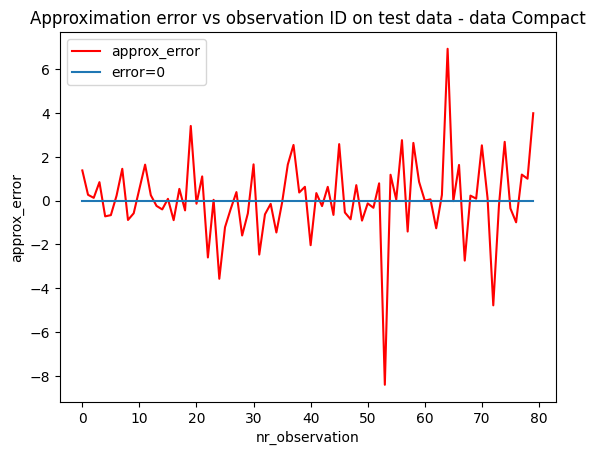

In [81]:
plot_x = [i for i in range(len(eval(name_of_X_test_of_best_model_on_test_data)))] #zakres x do rysowania na wykresie (indeksy po zbiorze testowym)
plot_y_pred = best_model_predicts_test_data[0] #predykcje naszego  modelu na zbiorze testowym
plot_y_real = real_model_values_test_data #prawdziwe wartości na zbiorze testowym
plt.plot(plot_x, plot_y_pred-plot_y_real, color = 'red',label='approx_error') #narysowanie krzywej błędu przybliżenia
plt.plot(plot_x, [0 for i in range(len(plot_x))], label='error=0') #narysowanie linii y = 0
plt.xlabel('nr_observation')
plt.ylabel('approx_error')
plt.legend()
plt.title('Approximation error vs observation ID on test data - data Compact')
plt.show() #a oto wykres błędu przybliżenia względem numeru obserwacji

Dla większej czytelności, narysujmy wykres procentowego błędu (względnego) przybliżenia:

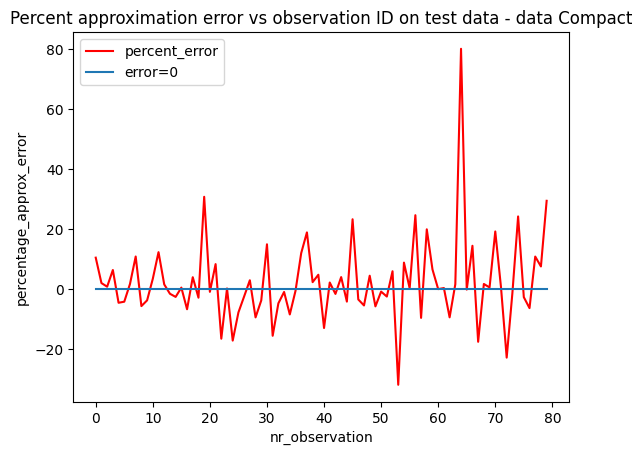

In [82]:
plt.plot(plot_x,100*(plot_y_pred-plot_y_real)/plot_y_real, color = 'red',label='percent_error') #narysowanie krzywej błędu procentowego (względnego) przybliżenia
plt.plot(plot_x, [0 for i in range(len(plot_x))], label = 'error=0') #narysowanie linii y = 0
plt.xlabel('nr_observation')
plt.ylabel('percentage_approx_error')
plt.legend()
plt.title('Percent approximation error vs observation ID on test data - data Compact')
plt.show() #a oto wykres procentowego (względnego) błędu przybliżenia względem numeru obserwacji

Jak widać, błędy są na naprawdę przyzwoicie niskim (procentowym) poziomie - oscylują one wokół 10 procent. Narysujmy teraz na jednym wykresie predykcje, przedziały ufności wokół predykcji oraz oryginalne dane:

<>:4: SyntaxWarning:

invalid escape sequence '\p'

<>:5: SyntaxWarning:

invalid escape sequence '\p'

<>:4: SyntaxWarning:

invalid escape sequence '\p'

<>:5: SyntaxWarning:

invalid escape sequence '\p'

C:\Users\piotr\AppData\Local\Temp\ipykernel_25316\3175655897.py:4: SyntaxWarning:

invalid escape sequence '\p'

C:\Users\piotr\AppData\Local\Temp\ipykernel_25316\3175655897.py:5: SyntaxWarning:

invalid escape sequence '\p'



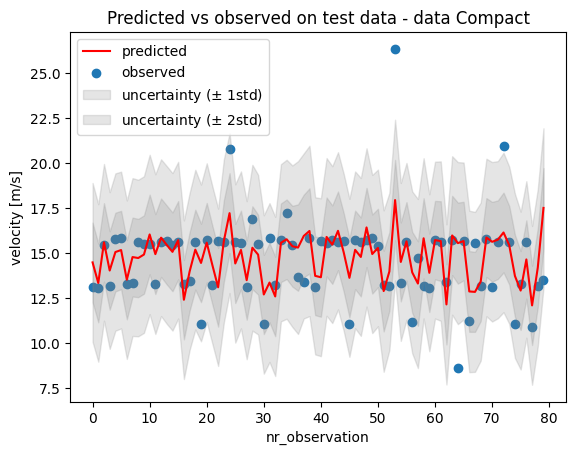

In [83]:
plot_y_err = best_model_predicts_test_data[1] #błędy (standardowe) niepewności dla poszczególnych obserwacji (zwrócone przez metodę predict)
plt.plot(plot_x,plot_y_pred, color = 'red',label='predicted') #narysowanie krzywej predykcji
plt.scatter(plot_x,plot_y_real, label = 'observed') #zaznaczenie punktów oznaczających oryginalne dane
plt.fill_between(plot_x, plot_y_pred - plot_y_err, plot_y_pred + plot_y_err, color='gray', alpha=0.2, label='uncertainty ($\pm$ 1std)')
plt.fill_between(plot_x, plot_y_pred - 2*plot_y_err, plot_y_pred + 2*plot_y_err, color='gray', alpha=0.2, label='uncertainty ($\pm$ 2std)')
plt.xlabel('nr_observation')
plt.ylabel('velocity [m/s]')
plt.legend()
plt.title('Predicted vs observed on test data - data Compact')
plt.show() #a oto wykres błędu przybliżenia względem numeru obserwacji + zaznaczone obserwacje

Jak więc widać, predykcje są dosyć zgodne z faktycznie zaobserwowanymi wartościami. Teraz wykonamy te same wykresy dla danych z klasy Luxury, dla modelu zbudowanego na danych po standaryzacji. Najpierw wyznaczę predykcje i zbiorę oryginalne wartości:

In [84]:
model_luxury_std_predicts = model_luxury_std.predict(eval("X_luxury_std_test"),return_std=True) #predykcje na zb. testowym
#tutaj model_luxury_std_predicts_test_data[0] to są predykcje, natomiastmodel_luxury_std_predicts_test_data[1] to są błędy w odpowiednich punktach

model_luxury_std_real_test = np.array([i[0] for i in eval("y_luxury_test").to_numpy()]) #prawdziwe wartości na zb. testowym

Najpierw narysujmy wykres błędu przybliżenia dla kolejnych obserwacji:

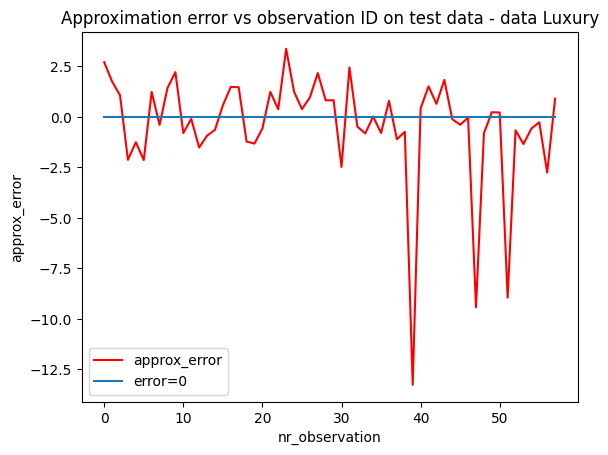

In [85]:
plot_x_luxury = [i for i in range(len(eval("X_luxury_std_test")))] #zakres x do rysowania na wykresie (indeksy po zbiorze testowym)
plot_y_pred_luxury = model_luxury_std_predicts[0] #predykcje naszego modelu na zbiorze testowym
plot_y_real_luxury = model_luxury_std_real_test #prawdziwe wartości na zbiorze testowym
plt.plot(plot_x_luxury, plot_y_pred_luxury-plot_y_real_luxury, color = 'red',label='approx_error') #narysowanie krzywej błędu przybliżenia
plt.plot(plot_x_luxury, [0 for i in range(len(plot_x_luxury))], label='error=0') #narysowanie linii y = 0
plt.xlabel('nr_observation')
plt.ylabel('approx_error')
plt.legend()
plt.title('Approximation error vs observation ID on test data - data Luxury')
plt.show() #a oto wykres błędu przybliżenia względem numeru obserwacji

Teraz narysujemy wykres błędu procentowego:

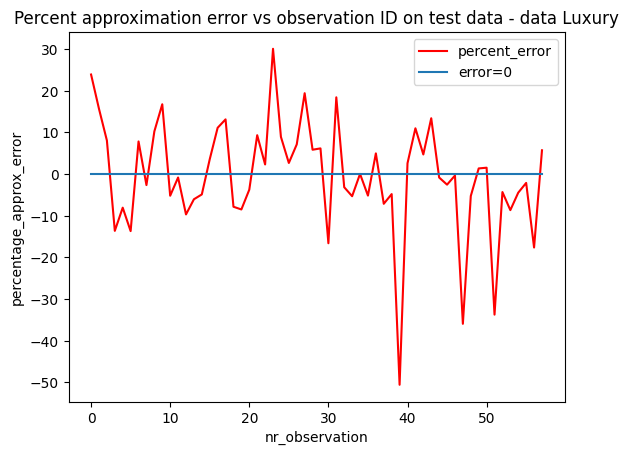

In [86]:
plt.plot(plot_x_luxury,100*(plot_y_pred_luxury-plot_y_real_luxury)/plot_y_real_luxury, color = 'red',label='percent_error') #narysowanie krzywej błędu procentowego (względnego) przybliżenia
plt.plot(plot_x_luxury, [0 for i in range(len(plot_x_luxury))], label = 'error=0') #narysowanie linii y = 0
plt.xlabel('nr_observation')
plt.ylabel('percentage_approx_error')
plt.legend()
plt.title('Percent approximation error vs observation ID on test data - data Luxury')
plt.show() #a oto wykres procentowego (względnego) błędu przybliżenia względem numeru obserwacji

Jak widać, błędy są na naprawdę przyzwoicie niskim (procentowym) poziomie - oscylują one wokół 10 procent. Narysujmy teraz na jednym wykresie predykcje, przedziały ufności wokół predykcji oraz oryginalne dane:

<>:4: SyntaxWarning:

invalid escape sequence '\p'

<>:5: SyntaxWarning:

invalid escape sequence '\p'

<>:4: SyntaxWarning:

invalid escape sequence '\p'

<>:5: SyntaxWarning:

invalid escape sequence '\p'

C:\Users\piotr\AppData\Local\Temp\ipykernel_25316\1620236896.py:4: SyntaxWarning:

invalid escape sequence '\p'

C:\Users\piotr\AppData\Local\Temp\ipykernel_25316\1620236896.py:5: SyntaxWarning:

invalid escape sequence '\p'



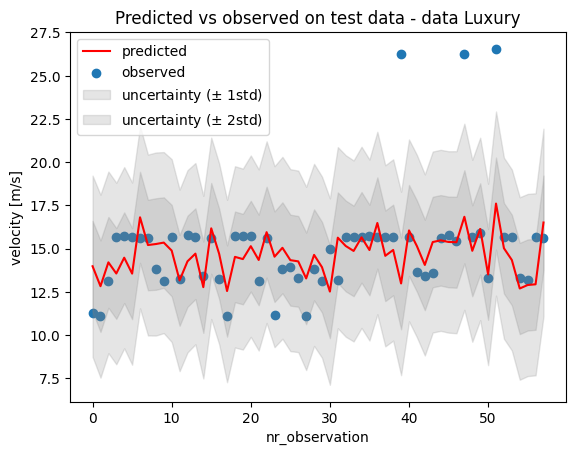

In [87]:
plot_y_err_luxury = model_luxury_std_predicts[1] #błędy (standardowe) niepewności dla poszczególnych obserwacji (zwrócone przez metodę predict)
plt.plot(plot_x_luxury,plot_y_pred_luxury, color = 'red',label='predicted') #narysowanie krzywej predykcji
plt.scatter(plot_x_luxury,plot_y_real_luxury, label = 'observed') #zaznaczenie punktów oznaczających oryginalne dane
plt.fill_between(plot_x_luxury, plot_y_pred_luxury - plot_y_err_luxury, plot_y_pred_luxury + plot_y_err_luxury, color='gray', alpha=0.2, label='uncertainty ($\pm$ 1std)')
plt.fill_between(plot_x_luxury, plot_y_pred_luxury - 2*plot_y_err_luxury, plot_y_pred_luxury + 2*plot_y_err_luxury, color='gray', alpha=0.2, label='uncertainty ($\pm$ 2std)')
plt.xlabel('nr_observation')
plt.ylabel('velocity [m/s]')
plt.legend()
plt.title('Predicted vs observed on test data - data Luxury')
plt.show() #a oto wykres błędu przybliżenia względem numeru obserwacji + zaznaczone obserwacje

# 7. A tak czysto, z ciekawości... regresja liniowa.

Z ciekawości, zobaczmy jakie wyniki dałaby zwykła regresja wieloraka (nie wiemy jednak, czy tak naprawdę 'wolno' nam z niej skorzystać, tzn. czy jej teoretyczne założenia są spełnione). Importujemy moduł LinearRegression z pakietu scikit (link do dokumentacji:[link](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)):

In [88]:
from sklearn.linear_model import LinearRegression

Tworzymy pustą zmienną typu LinearRegression, w której za chwilę będzie nasz model:

In [89]:
linear_model = LinearRegression()

Teraz trenujemy ten model:

In [90]:
linear_model.fit(eval(name_of_X_test_of_best_model_on_test_data.replace('test','train')), eval(name_of_y_test_of_best_model_on_test_data.replace('test','train')))

LinearRegression()

Teraz wyznaczamy predykcje na zbiorze testowym:

In [91]:
linear_model_predictions = linear_model.predict(eval(name_of_X_test_of_best_model_on_test_data))

Teraz wyznaczamy ocenę MAE tego modelu na zbiorze testowym:

In [92]:
linear_model_mae_score_on_test_data = mean_absolute_error(eval(name_of_y_test_of_best_model_on_test_data), linear_model_predictions)

I wyświetlamy wynik:

In [93]:
print('MAE(Multiple_Linear_Regression_Model) = ', linear_model_mae_score_on_test_data, ', tzn. ', 100*linear_model_mae_score_on_test_data/np.mean(eval(name_of_y_test_of_best_model_on_test_data)), '% średniej wartości.')

MAE(Multiple_Linear_Regression_Model) =  1.3556226754732723 , tzn.  9.219788753864133 % średniej wartości.


Jak widać, nawet nieźle, ale i tak o prawie 1 punkt procentowy gorzej niż najlepszy model GPR :-)